# Webscraping Example

### Objectives
Demostrate ability to scrape data from a website.
Do some basic analysis, data cleansing and visualisations  

Install packages

In [545]:
!pip install bs4
!pip install requests
!pip install pandas
!pip install matplotlib
!pip install seaborn

Import packages

In [546]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

### 1. Scrape data
Create a function to convert an html table to a pandas dataframe

In [547]:
def html_to_dataframe(table, contains_column_headers):
    rows = table.find_all('tr')
    for index, row in enumerate(rows):
        if contains_column_headers == True and index == 0:
            headers_list = []
            for cell in row:
                cell_text = cell.text.strip()
                if len(cell_text) > 0:
                    headers_list += [cell_text]
                df = pd.DataFrame(columns = headers_list)
        else:
            row_list = []
            for cell in row:
                cell_text = cell.text.strip()
                if len(cell_text) > 0:
                    row_list += [cell_text]
                if contains_column_headers == False and index == 0:
                    headers_list = list(range(len(row_list)))
                    df = pd.DataFrame(columns = headers_list)
                if len(row_list) == len(headers_list):
                    new_row = pd.DataFrame([row_list], columns = headers_list)
                    df = pd.concat([df, new_row], ignore_index=True)
    return df

Use requests package to retrieve the html for the Wikipedia page: (https://en.wikipedia.org/wiki/List_of_English_football_champions), then parse the html with the BeautifulSoup package

In [548]:
url ='https://en.wikipedia.org/wiki/List_of_English_football_champions'
headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
html = requests.get(url, headers=headers).text
soup = BeautifulSoup(html, 'html.parser')

# print(soup)

Scrape the first table after the 'List of champions by season' header and convert it to a dataframe

In [549]:
header = soup.find('h2', {'id': 'List_of_champions_by_season'})
first_table = header.find_next('table')
symbols_df = html_to_dataframe(first_table, False)
symbols_df = symbols_df.rename(columns={0:'Symbol', 1:'Description'})
symbols_df.set_index('Symbol', inplace=True)

symbols_df

,Description
Symbol,
‡,Winning team won the Double (League title and ...
†,Winning team also won the European Cup/UEFA Ch...
₮,Winning team won the Domestic Treble (League t...
#,Winning team won the Continental Treble (Leagu...


Scrape the data table of winners and runners up

In [550]:
second_table = first_table.find_next('table')
contains_column_headers = True
df = html_to_dataframe(second_table, True)
df.set_index('Ed.', inplace=True)

df.head(5)

,Season,Champions (number of titles),Runners-up,Third place
Ed.,,,,
1,1888–89,Preston North End[a][b] (1) ‡,Aston Villa (1),Wolverhampton Wanderers
2,1889–90,Preston North End (2),Everton (1),Blackburn Rovers
3,1890–91,Everton (1),Preston North End (1),Notts County
4,1891–92,Sunderland (1),Preston North End (2),Bolton Wanderers
5,1892–93,Sunderland (2),Preston North End (3),Everton


Scrape the ordered list under the Notes header

In [551]:
header = soup.find('h2', {'id': 'Notes'})
line = header.find_next()
headers_list = list(range(2))
notes_df = pd.DataFrame(columns = headers_list)
index = 97
while line:
    if line.name == 'h2':  
        break
    if line.name == 'li': 
        char = chr(index)
        note = re.search(r'[A-Z].*', line.text.strip()).group()
        new_row = pd.DataFrame([[char, note]], columns = headers_list)
        notes_df = pd.concat([notes_df, new_row], ignore_index=True)
        index +=1
    line = line.find_next() 
notes_df = notes_df.rename(columns={0:'Key', 1:'Notes'})
notes_df['Key'] = notes_df['Key'].apply(lambda x: f'[{x}]')
notes_df.set_index('Key', inplace=True)

notes_df.head(5)

,Notes
Key,
[a],Completed the season unbeaten.
[b],Also won the FA Cup
[c],Sheffield Wednesday were known as The Wednesda...
[d],Also won the UEFA Cup/UEFA Europa League.
[e],Also won the European Cup/UEFA Champions League.


### 2. Clease the data
Add a column to the symbols dataframe to determine the columns to be added to the main dataset

In [552]:
symbols_df['Create Column'] = None
new_cols = {'‡': 'Domestic Double',
              '†': 'Continental Double',
              '₮': 'Domestic Treble',
              '#': 'Continental Treble'}
for col in new_cols:
    symbols_df.loc[col, 'Create Column'] = new_cols[col]

print(list(symbols_df['Create Column'][pd.notna(symbols_df['Create Column'])]))
symbols_df[pd.notna(symbols_df['Create Column'])].head(5)

['Domestic Double', 'Continental Double', 'Domestic Treble', 'Continental Treble']


,Description,Create Column
Symbol,,
‡,Winning team won the Double (League title and ...,Domestic Double
†,Winning team also won the European Cup/UEFA Ch...,Continental Double
₮,Winning team won the Domestic Treble (League t...,Domestic Treble
#,Winning team won the Continental Treble (Leagu...,Continental Treble


Add a column to the notes dataframe to determine the columns to be added to the main dataset

In [553]:
notes_df['Create Column'] = None
new_cols = {'[a]': 'Unbeaten',
            '[b]': 'FA Cup',
            '[d]': 'UEFA Cup/UEFA Europa League',
            '[e]': 'European Cup/UEFA Champions League',
            '[f]': 'League Cup/EFL Cup',
            '[h]': 'UEFA Cup Winners Cup',
            '[j]': 'Intercontinental Cup',
            '[k]': 'FIFA Club World Cup'}
for col in new_cols:
    notes_df.loc[col, 'Create Column'] = new_cols[col]

print(list(notes_df['Create Column'][pd.notna(notes_df['Create Column'])]))
notes_df[pd.notna(notes_df['Create Column'])].head(5)

['Unbeaten', 'FA Cup', 'UEFA Cup/UEFA Europa League', 'European Cup/UEFA Champions League', 'League Cup/EFL Cup', 'UEFA Cup Winners Cup', 'Intercontinental Cup', 'FIFA Club World Cup']


,Notes,Create Column
Key,,
[a],Completed the season unbeaten.,Unbeaten
[b],Also won the FA Cup,FA Cup
[d],Also won the UEFA Cup/UEFA Europa League.,UEFA Cup/UEFA Europa League
[e],Also won the European Cup/UEFA Champions League.,European Cup/UEFA Champions League
[f],Also won the League Cup/EFL Cup.,League Cup/EFL Cup


Create new columns in the main dataset, based on Symbols and Notes

In [554]:
for index, row in symbols_df[pd.notna(symbols_df['Create Column'])].iterrows():
    df[row['Create Column']] = df['Champions (number of titles)'].str.contains(re.escape(index), na=False)

for index, row in notes_df[pd.notna(notes_df['Create Column'])].iterrows():
    df[row['Create Column']] = df['Champions (number of titles)'].str.contains(re.escape(index), na=False)

df.head(5)

,Season,Champions (number of titles),Runners-up,Third place,Domestic Double,Continental Double,Domestic Treble,Continental Treble,Unbeaten,FA Cup,UEFA Cup/UEFA Europa League,European Cup/UEFA Champions League,League Cup/EFL Cup,UEFA Cup Winners Cup,Intercontinental Cup,FIFA Club World Cup
Ed.,,,,,,,,,,,,,,,,
1,1888–89,Preston North End[a][b] (1) ‡,Aston Villa (1),Wolverhampton Wanderers,True,False,False,False,True,True,False,False,False,False,False,False
2,1889–90,Preston North End (2),Everton (1),Blackburn Rovers,False,False,False,False,False,False,False,False,False,False,False,False
3,1890–91,Everton (1),Preston North End (1),Notts County,False,False,False,False,False,False,False,False,False,False,False,False
4,1891–92,Sunderland (1),Preston North End (2),Bolton Wanderers,False,False,False,False,False,False,False,False,False,False,False,False
5,1892–93,Sunderland (2),Preston North End (3),Everton,False,False,False,False,False,False,False,False,False,False,False,False


Split number of titles into a new column

In [555]:
df['Number of Titles'] = df['Champions (number of titles)'].str.extract(r'\((.*?)\)').astype(int)
for col in ['Champions (number of titles)', 'Runners-up']:
    df[col] = df[col].str.replace(r'\(.*', '', regex=True).str.strip()
df = df.rename(columns={'Champions (number of titles)': 'Champions'})

df[['Champions', 'Runners-up', 'Number of Titles']].head(5)

,Champions,Runners-up,Number of Titles
Ed.,,,
1,Preston North End[a][b],Aston Villa,1
2,Preston North End,Everton,2
3,Everton,Preston North End,1
4,Sunderland,Preston North End,1
5,Sunderland,Preston North End,2


Remove symbols and notes from data and replace 'The Wednesday' with 'Sheffield Wednesday' as per note c

In [556]:
df['Champions'] = df['Champions'].str.replace(r'\[.*', '', regex=True).str.strip()
df['Season'] = df['Season'].str.replace(r'\[.*', '', regex=True).str.strip()

for index, row in symbols_df[pd.notna(symbols_df['Create Column'])].iterrows():
    df['Champions'] = df['Champions'].str.replace(re.escape(index), '', regex=True).str.strip()

df['Champions'] = df['Champions'].str.replace('The Wednesday', 'Sheffield Wednesday', regex=True).str.strip()

print(list(df['Champions'].unique()))
df.head(5)

['Preston North End', 'Everton', 'Sunderland', 'Aston Villa', 'Sheffield United', 'Liverpool', 'Sheffield Wednesday', 'Newcastle United', 'Manchester United', 'Blackburn Rovers', 'West Bromwich Albion', 'Burnley', 'Huddersfield Town', 'Arsenal', 'Manchester City', 'Portsmouth', 'Tottenham Hotspur', 'Wolverhampton Wanderers', 'Chelsea', 'Ipswich Town', 'Leeds United', 'Derby County', 'Nottingham Forest', 'Leicester City']


,Season,Champions,Runners-up,Third place,Domestic Double,Continental Double,Domestic Treble,Continental Treble,Unbeaten,FA Cup,UEFA Cup/UEFA Europa League,European Cup/UEFA Champions League,League Cup/EFL Cup,UEFA Cup Winners Cup,Intercontinental Cup,FIFA Club World Cup,Number of Titles
Ed.,,,,,,,,,,,,,,,,,
1,1888–89,Preston North End,Aston Villa,Wolverhampton Wanderers,True,False,False,False,True,True,False,False,False,False,False,False,1
2,1889–90,Preston North End,Everton,Blackburn Rovers,False,False,False,False,False,False,False,False,False,False,False,False,2
3,1890–91,Everton,Preston North End,Notts County,False,False,False,False,False,False,False,False,False,False,False,False,1
4,1891–92,Sunderland,Preston North End,Bolton Wanderers,False,False,False,False,False,False,False,False,False,False,False,False,1
5,1892–93,Sunderland,Preston North End,Everton,False,False,False,False,False,False,False,False,False,False,False,False,2


Check number of columns, rows, data types and distribution

In [557]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 1 to 126
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Season                              126 non-null    object
 1   Champions                           126 non-null    object
 2   Runners-up                          126 non-null    object
 3   Third place                         126 non-null    object
 4   Domestic Double                     126 non-null    bool  
 5   Continental Double                  126 non-null    bool  
 6   Domestic Treble                     126 non-null    bool  
 7   Continental Treble                  126 non-null    bool  
 8   Unbeaten                            126 non-null    bool  
 9   FA Cup                              126 non-null    bool  
 10  UEFA Cup/UEFA Europa League         126 non-null    bool  
 11  European Cup/UEFA Champions League  126 non-null    bool  
 12 

,Number of Titles
count,126.000000
mean,5.912698
std,5.131892
min,1.000000
25%,2.000000
50%,4.000000
75%,8.750000
max,20.000000


Check for null values

In [558]:
df.isnull().sum()

Season                                0
Champions                             0
Runners-up                            0
Third place                           0
Domestic Double                       0
Continental Double                    0
Domestic Treble                       0
Continental Treble                    0
Unbeaten                              0
FA Cup                                0
UEFA Cup/UEFA Europa League           0
European Cup/UEFA Champions League    0
League Cup/EFL Cup                    0
UEFA Cup Winners Cup                  0
Intercontinental Cup                  0
FIFA Club World Cup                   0
Number of Titles                      0
dtype: int64

### 3. Visualise the data
Top 5 champions, runners-up and third place finishes

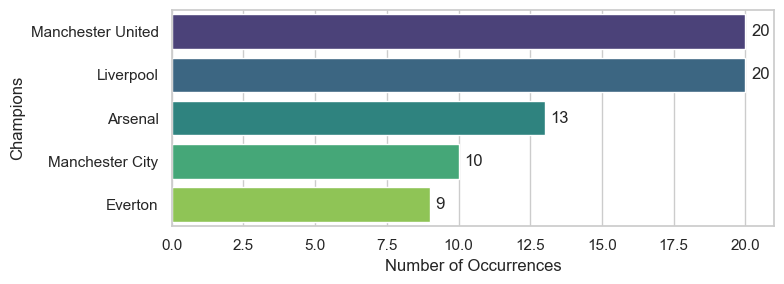

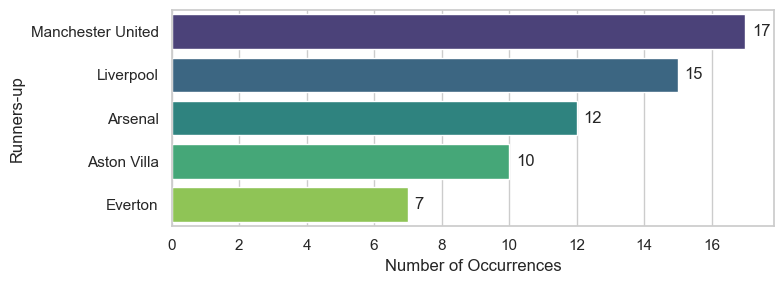

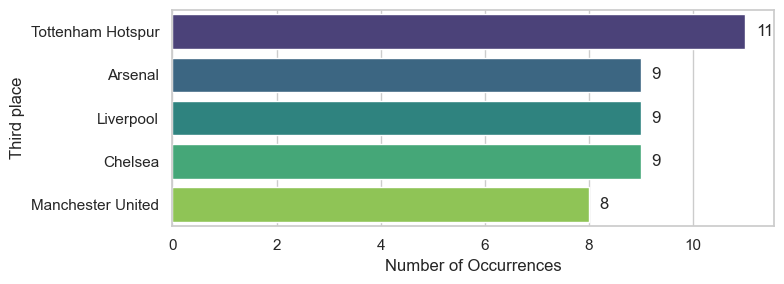

In [559]:
sns.set(style="whitegrid")

for col in ['Champions', 'Runners-up', 'Third place']:
    df_grouped = df.groupby(col).size().reset_index(name='Count')
    df_top5 = df_grouped.sort_values('Count', ascending=False).head(5)

    plt.figure(figsize=(8, 3))
    ax = sns.barplot(data=df_top5, x='Count', y=col, palette='viridis', hue = col, legend=False)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for i, (value, label) in enumerate(zip(df_top5['Count'], df_top5[col])):
        ax.text(value + 0.2, i, str(value), va='center')

    plt.xlabel('Number of Occurrences')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Doubles and Trebles

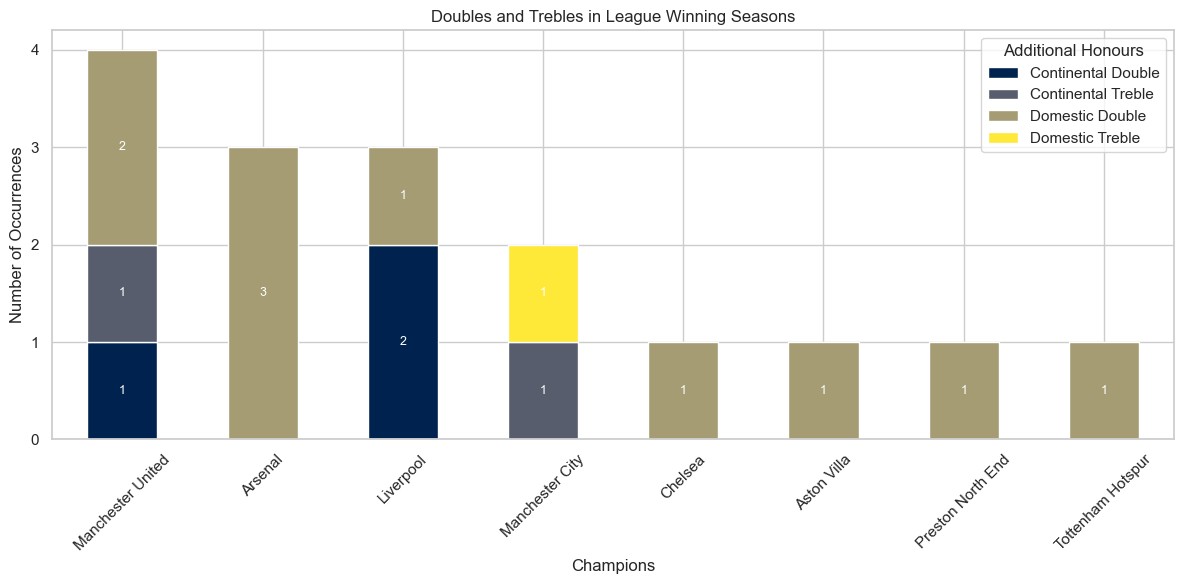

In [560]:
cols = list(symbols_df['Create Column'][pd.notna(symbols_df['Create Column'])])

df_append = pd.DataFrame()
for col in cols:
    df_grouped = df[df[col] == True].groupby('Champions').size().reset_index(name='Count')
    df_grouped = df_grouped.sort_values('Count', ascending=False)
    df_grouped['Additional Honours'] = col
    df_append = pd.concat([df_append, df_grouped], axis = 0)

df_pivot = df_append.pivot_table(index='Champions', columns='Additional Honours', values='Count', fill_value=0)

df_pivot['Total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values('Total', ascending=False).drop(columns='Total')

ax = df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='cividis')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v)}' if v > 0 else '' for v in container.datavalues], label_type='center', fontsize=9, color='white')
    
plt.title('Doubles and Trebles in League Winning Seasons')
plt.xlabel('Champions')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Additional achievements in league winning seasons

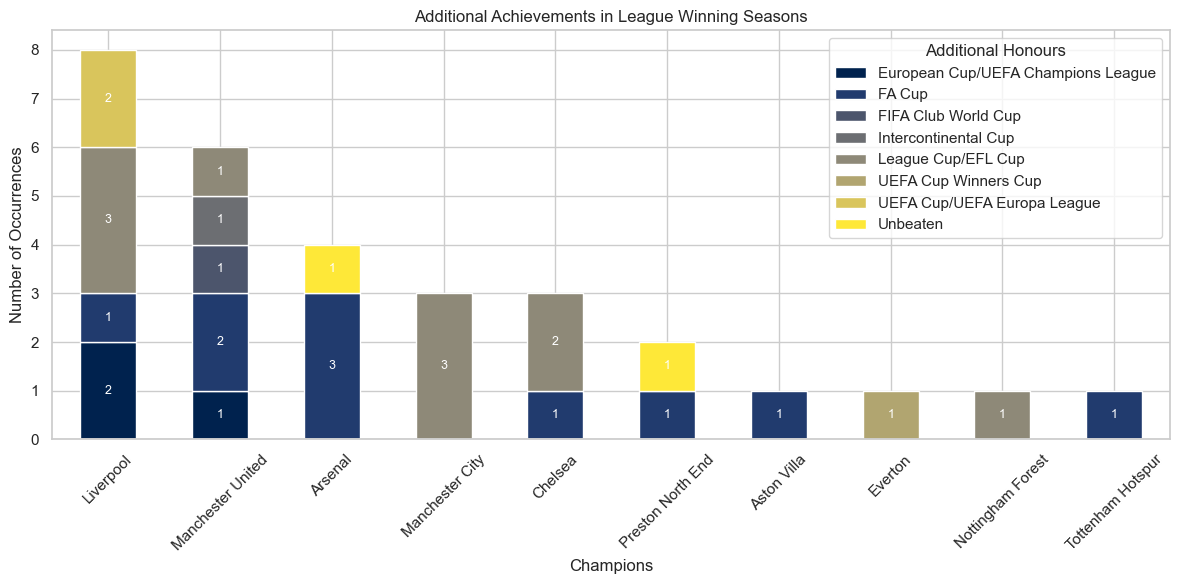

In [561]:
cols = list(notes_df['Create Column'][pd.notna(notes_df['Create Column'])])

df_append = pd.DataFrame()
for col in cols:
    df_grouped = df[df[col] == True].groupby('Champions').size().reset_index(name='Count')
    df_grouped = df_grouped.sort_values('Count', ascending=False)
    df_grouped['Additional Honours'] = col
    df_append = pd.concat([df_append, df_grouped], axis = 0)

df_pivot = df_append.pivot_table(index='Champions', columns='Additional Honours', values='Count', fill_value=0)

df_pivot['Total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values('Total', ascending=False).drop(columns='Total')

ax = df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='cividis')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v)}' if v > 0 else '' for v in container.datavalues], label_type='center', fontsize=9, color='white')
    
plt.title('Additional Achievements in League Winning Seasons')
plt.xlabel('Champions')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()